In [1]:
# Image utilities

import IPython, IPython.display
import numpy, PIL
import cStringIO
import scipy.ndimage
import scipy.misc

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

def fimg_ar_as_PIL(img_ar):
    return PIL.Image.fromarray(numpy.uint8(img_ar))
def fimg_PIL_as_ar(img_pil):
    return numpy.array(img_pil)
def fimg_ar_disp_IPython(img_ar):
    io = cStringIO.StringIO()
    fimg_ar_as_PIL(img_ar).save(io, 'bmp')
    IPython.display.display(IPython.display.Image(data=io.getvalue()))
def fimg_ar_disp(img_ar):
    fimg_ar_disp_IPython(img_ar)
import matplotlib.image
def fimg_load_ar(img_path):
    return matplotlib.image.imread(img_path)
def fimg_ar_size(img_ar):
    return (len(img_ar[0]) if img_ar is not None and len(img_ar) else 0.0, len(img_ar) if img_ar is not None else 0.0)
def fimg_ar_racoon():
    return scipy.misc.face()
def fimg_ar_resize(img_ar, scl):
    return scipy.ndimage.zoom(img_ar, (scl[0],scl[1],1))
def fimg_filled(img_sz, color_val = 0):
    img = np.zeros([img_sz[0],img_sz[1],3],dtype=np.uint8)
    if color_val != 0:
        img.fill(color_val)
    return img

In [2]:
# Pinhole camera renderer

import numpy as np

g_pinhole_f = 0.1
g_pinhole_sensor_sz = [0.1,0.1]
g_pihole_img_sz = [256,256]

def fpinhole_matrix(focal):
    return [[-focal, 0, 0],
            [0, -focal, 0],
            [0, 0, 1]]
def fpinhole_viewp(sensor_sz, img_sz):
    return [[img_sz[0]/sensor_sz[0], 0, img_sz[0]/2.0],
            [0, -img_sz[1]/sensor_sz[1], img_sz[1]/2.0],
            [0, 0, 1]]
def fpinhole_pin_pt(pin_mat, pt):
    homog = np.dot(pin_mat, pt)
    #print pt, homog
    return [homog[0]/homog[2], homog[1]/homog[2]]
def fpinhole_viewp_pt(viewp_mat, pt):
    viewp_pt = np.dot(viewp_mat, list(pt)+[1.0])
    return viewp_pt[0:2]
def fpinhole_project_img(pin_mat, viewp_mat, pts, img, pt_colors=[255,255,255]):
    img_sz = fimg_ar_size(img)
    for i_pt, pt in enumerate(pts):
        pin_pt = fpinhole_pin_pt(pin_mat, pt)
        img_pt = [int(x+0.5) for x in fpinhole_viewp_pt(viewp_mat, pin_pt)]
        #print img_pt
        if all([img_pt[i] >= 0 and img_pt[i] < img_sz[i] for i in range(2)]):
            img[img_pt[1]][img_pt[0]] = pt_colors[i_pt if i_pt < len(pt_colors) else 0]
def fpinhole_good_offset(sensor_sz, focal, rad):
    return -rad - max(focal, (focal * rad / (0.5 * min(sensor_sz)))) 
def ftest_pinhole():
    pin_img = fimg_filled(g_pihole_img_sz)
    pin_mat = fpinhole_matrix(g_pinhole_f)
    viewp_mat = fpinhole_viewp(g_pinhole_sensor_sz, g_pihole_img_sz)
    f = -g_pinhole_f
    pts = [ [0, 0, 2*f], 
           [-f/2,-f/2,2*f], [-f/2,f/2,2*f] , [f/2,f/2,2*f], [f/2,-f/2,2*f], 
           [-f/2,-f/2,3*f], [-f/2,f/2,3*f] , [f/2,f/2,3*f], [f/2,-f/2,3*f]
          ]
    pt_cols = [[255,255,255], [255,0,0], [0,0,255]]
    fpinhole_project_img(pin_mat, viewp_mat, pts, pin_img, pt_cols)
    fimg_ar_disp(pin_img)
#ftest_pinhole()

In [3]:
# 3D model loading (.obj) and processing

import re

def _fread_obj_vertices_str(obj_str):
    regex = r"^v\s(-?(0|[1-9]\d*)(\.\d+)?)\s(-?(0|[1-9]\d*)(\.\d+)?)\s(-?(0|[1-9]\d*)(\.\d+)?)"
    matches = re.finditer(regex, obj_str, re.MULTILINE)
    verts = []
    for i, match in enumerate(matches):
        verts.append([float(match.groups()[i]) for i in [0,3,6]])
    return verts
def fread_obj_vertices_str(obj_str):
    regex = r"^v\s(.+)\s(.+)\s(.+)"
    matches = re.finditer(regex, obj_str, re.MULTILINE)
    verts = []
    for i, match in enumerate(matches):
        verts.append([float(match.groups()[i]) for i in [0,1,2]])
    return verts
def fread_obj_vertices_file(file):
    verts = []
    with open(file) as fi:
        for line in fi:
            verts.extend(fread_obj_vertices_str(line))
    return verts
def ftest_obj():
    print fread_obj_vertices_file('./data/suzanne.obj')
def fbox_vertices(verts):
    box_max = reduce(lambda a,b: np.maximum(a,b), verts)
    box_min = reduce(lambda a,b: np.minimum(a,b), verts)
    return box_min, box_max
def fcenter_vertices(verts):
    box_min, box_max = fbox_vertices(verts)
    box_cent = 0.5*np.add(box_max, box_min)
    return [np.subtract(x, box_cent) for x in verts]
def frad_vertices(verts):
    box_min, box_max = fbox_vertices(verts)
    return max(np.maximum(np.absolute(box_min), np.absolute(box_max)))
#ftest_obj()

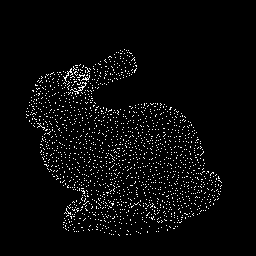

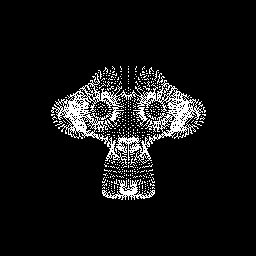

In [4]:
def frender_model(file = './data/bunny.obj'):
    pin_img = fimg_filled(g_pihole_img_sz)
    pin_mat = fpinhole_matrix(g_pinhole_f)
    viewp_mat = fpinhole_viewp(g_pinhole_sensor_sz, g_pihole_img_sz)
    pts = fcenter_vertices(fread_obj_vertices_file(file))
    rad = frad_vertices(pts)
    off_z = fpinhole_good_offset(g_pinhole_sensor_sz, g_pinhole_f, rad)
    pts = [x + [0.0, 0.0, off_z] for x in pts]
    fpinhole_project_img(pin_mat, viewp_mat, pts, pin_img)
    fimg_ar_disp(pin_img)

frender_model('./data/bunny.obj')
frender_model('./data/suzanne.obj')